![Clase aprendizaje no supervisado](https://raw.githubusercontent.com/MECA4605-Aprendizaje-no-supervisado/taller_1/main/figs/taller-meca-aprendizaje%20no%20supervisado_banner%201169%20x%20200%20px%20-05.png)

# Caso-taller:  SVD en reconocimiento facial

En este caso-taller vamos a aplicar SVD para hacer reconocimiento facial. Esta aplicación se conoce como caras propias, o eigenfaces en inglés, y si bien es una forma rudimentaria de reconocimiento facial sus resultados pueden ser muy interesantes. El problema de las caras propias fue estudiado por primera vez por Sirovich y Kirby en 1987, ampliado en 1990 y su aplicación al reconocimiento facial automatizado fue presentado por Turk and Pentland en 1991.

En este taller vamos a utilizar la base de datos conocida como Caras Etiquetadas en la Naturaleza, o Labeled Faces in the Wild (LFW). Esta base es provista por la Universidad de Massachusetts Amherst para que la comunidad académica la utilice para la evaluación de modelos predictivos.

La base contiene más de 13.000 imágenes de rostros recopilados de la web y cada cara ha sido etiquetada con el nombre de la persona representada. Un subconjunto de 1.680 de las personas fotografiadas tienen dos o más fotos distintas en el conjunto de datos.



#### Referencias

- G. B. Huang,  M. Ramesh, T. Berg, and E. Learned-Miller. Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments. University of Massachusetts, Amherst, Technical Report 07-49, October, 2007.

- M. Kirby and L. Sirovich. Application of the Karhunen-Loève procedure for the characterization of human faces. IEEE Transactions on Pattern Analysis and Machine Intelligence (PAMI), 12(1):103–108, 1990.

- L. Sirovich and M. Kirby. A low-dimensional procedure for the characterization of human faces. Journal of the Optical Society of America A, 4(3):519–524, 1987

- M. Turk and A. Pentland. Eigenfaces for recognition. Journal of Cognitive Neuroscience, 3(1):71–86, 1991.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos  en la misma ruta de acceso del cuaderno, por ejemplo: `data`.

## Desarrollo


### 1. Carga de datos

Los datos pueden ser descargados directamente utilizando la librería `scikit-learn`, para ello cargue la base utilizando la función `fetch_lfw_people`. Esta función verificará si los datos están disponibles. De no estarlo, `scikit-learn` los descargará automáticamente desde el sitio web de la Universidad de Massachusetts. Descargue las imágenes para individuos que tengan al menos 25 imágenes y guárdelos en una carpeta llamada `data` usando esta función.

In [16]:
# Librerias
from sklearn.datasets import fetch_lfw_people
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd

In [4]:
# Cargar datos
min_faces = 25
lfw_dataset = fetch_lfw_people(data_home = "data", min_faces_per_person = min_faces)

(Utilice este espacio para describir su procedimiento)

### 2.  Análisis preliminar

Describa los contenidos de la base, tenga en cuenta que debe detallar los elementos, la dimensión de la base, y la dimensión de las imágenes.

In [5]:
n_samples, h, w = lfw_dataset.images.shape
print(f"La base de datos tiene {n_samples} personas con al menos {min_faces} imagenes, cada una de ellas tiene un tamaño de {h} pixeles de alto por {w} pixeles de ancho")

La base de datos tiene 2588 personas con al menos 25 imagenes, cada una de ellas tiene un tamaño de 62 pixeles de alto por 47 pixeles de ancho


In [6]:
# descripcion de la base de datos

descripcion = lfw_dataset.DESCR

lineas = descripcion.split("\n")  # Dividir la descripcion en lineas
for linea in lineas:
    if linea.strip():  # Evitar lineas vacías
        print(f"{linea.strip()}\n")


.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset

------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected

over the internet, all details are available on the official website:

http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called

Face Verification: given a pair of two pictures, a binary classifier

must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:

given the picture of the face of an unknown person, identify the name

of the person by referring to a gallery of previously seen pictures of

identified persons.

Both Face Verification and Face Recognition are tasks that are typically

performed on the output of a model trained to perform Face Detection. The

most popular model for Face Detection is called Viola-Jones and is

implemented in the

In [7]:
#Aplasto los datos para poder trabajar "mas intuitivamente" con las matrices
X = pd.DataFrame(lfw_dataset.data)

# id personas
y = pd.DataFrame(lfw_dataset.target, columns=['pid'])

# nombres personas
z = lfw_dataset.target_names
# mapeamos el array para agregar los nombres a nuestra base
y['name'] = y['pid'].map(lambda pid: z[pid])

# Consolidar todo en un solo DataFrame
df = pd.concat([y, X], axis=1)

# Mostrar primeros registros
df.head()

pid               name         0         1         2         3         4  \
0   10  Gerhard Schroeder  0.152941  0.193464  0.202614  0.236601  0.304575   
1    9      George W Bush  0.200000  0.214379  0.231373  0.256209  0.278431   
2   41     Vladimir Putin  0.375163  0.380392  0.435294  0.586928  0.632680   
3    6       Colin Powell  0.712418  0.707190  0.624837  0.465359  0.403922   
4    9      George W Bush  0.367320  0.443137  0.566013  0.641830  0.686275   

          5         6         7  ...      2904      2905      2906      2907  \
0  0.383007  0.441830  0.443137  ...  0.134641  0.137255  0.147712  0.155556   
1  0.299346  0.316340  0.339869  ...  0.551634  0.794771  0.926797  0.930719   
2  0.639216  0.671895  0.688889  ...  0.989542  1.000000  0.929412  0.369935   
3  0.430065  0.572549  0.671896  ...  0.363399  0.381699  0.437909  0.466667   
4  0.667974  0.607843  0.577778  ...  0.049673  0.069281  0.079739  0.086275   

       2908      2909      2910      2911      2912      2913  
0  0.162092  0.166013  0.173856  0.179085  0.183007  0.186928  
1  0.894118  0.887582  0.926797  0.909804  0.816993  0.630065  
2  0.070588  0.094118  0.084967  0.090196  0.090196  0.090196  
3  0.464052  0.481046  0.503268  0.420915  0.107190  0.060131  
4  0.096732  0.039216  0.062745  0.071895  0.083660  0.078431  

[5 rows x 2916 columns]

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

A continuación responda las siguientes preguntas:

- ¿Cuál es la distribución de imágenes por individuos?

In [8]:
# distribucion de la frecuencia de nombres
df.groupby(by = "name")["name"].count().sort_values(ascending = False)

name
George W Bush                530
Colin Powell                 236
Tony Blair                   144
Donald Rumsfeld              121
Gerhard Schroeder            109
Ariel Sharon                  77
Hugo Chavez                   71
Junichiro Koizumi             60
Jean Chretien                 55
John Ashcroft                 53
Serena Williams               52
Jacques Chirac                52
Vladimir Putin                49
Luiz Inacio Lula da Silva     48
Gloria Macapagal Arroyo       44
Jennifer Capriati             42
Arnold Schwarzenegger         42
Lleyton Hewitt                41
Laura Bush                    41
Alejandro Toledo              39
Hans Blix                     39
Nestor Kirchner               37
Andre Agassi                  36
Alvaro Uribe                  35
Tom Ridge                     33
Silvio Berlusconi             33
Megawati Sukarnoputri         33
Roh Moo-hyun                  32
Vicente Fox                   32
Kofi Annan                    32
John 

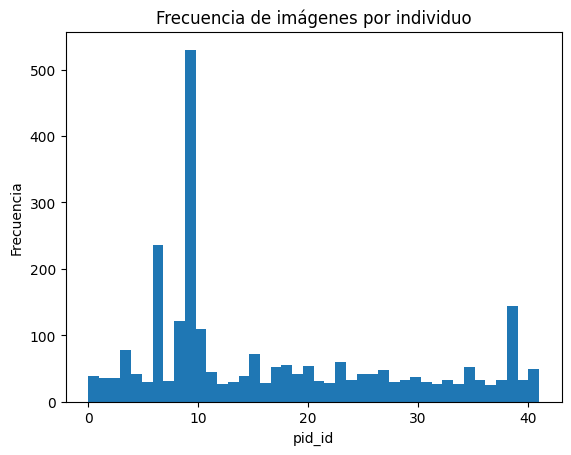

In [9]:
# histograma de frecuencia
fig, ax = plt.subplots()
ax.hist(df["pid"], bins = 42)
ax.set_title("Frecuencia de imágenes por individuo")
ax.set_xlabel("pid_id")
ax.set_ylabel("Frecuencia")
plt.show()

- ¿Cuántas imágenes pertenecen a Serena Williams? Grafíquelas

52 imagenes pertenecen a Serena Wiliams


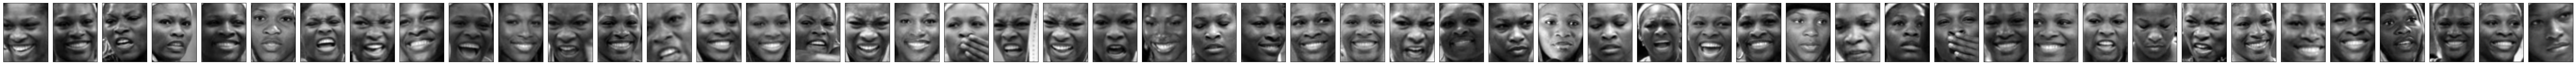

In [10]:
# filtrar las imagenes deseadas
serena_faces = df[df['name'] == 'Serena Williams'].drop(columns = ['pid', 'name'])

# cuantas imagenes graficar
n_faces = len(serena_faces)
n_row = 1
n_col = n_faces
print(f"{n_faces} imagenes pertenecen a Serena Wiliams")

# crear figura
plt.figure(figsize = (1.5 * n_col, 2.2 * n_row))
# margenes
plt.subplots_adjust(0.1, 0.1, 0.9, 0.9)

for i in range(n_faces):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(serena_faces.iloc[i].to_numpy().reshape((h, w)), cmap = plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()
plt.show()

### 3.  Reconociendo rostros: las eigenfaces

Las eigenfaces son un conjunto de eigenvectors utilizados en el campo de la visión por computadora, principalmente en el reconocimiento de rostros. Son el resultado de reducir la dimensión de un gran conjunto de imágenes faciales, manteniendo la información que es más relevante para diferenciar las caras.

En este apartado buscaremos encontrar el espacio de menor dimensión manteniendo la información que es más relevante para diferenciar las caras. Lo haremos en etapas:


#### 3.1. Rostro promedio.

Encuentre primero el "rostro promedio" y grafíquelo.  Para encontrar este rostro, necesita calcular el valor promedio de los pixeles. (*Tip: Si X es la matriz donde las filas representan las imágenes  y en las columnas el tono de gris de los píxeles, debería calcular el promedio para cada una de las columnas*).


In [11]:
# calcular rostro promedio
Xmean = df.drop(columns = ["pid", "name"]).mean(axis = 0)

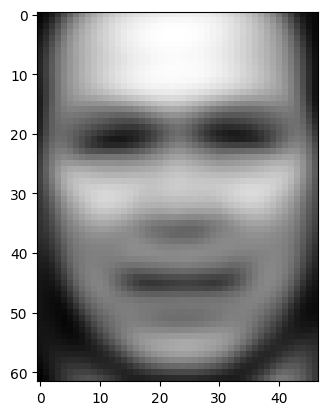

In [12]:
# plot the average face
plt.imshow(Xmean.to_numpy().reshape((h, w)), cmap = plt.cm.gray)

#### 3.2. Reste el rostro promedio.

A cada una de las imágenes, reste el rostro promedio, es decir, reste la media a cada columna. Grafique las imágenes de Serena Williams luego de quitarle el rostro promedio.

In [13]:
# restar el rostro promedio en base de datos
Demean = df.drop(columns = ["pid", "name"]) - Xmean

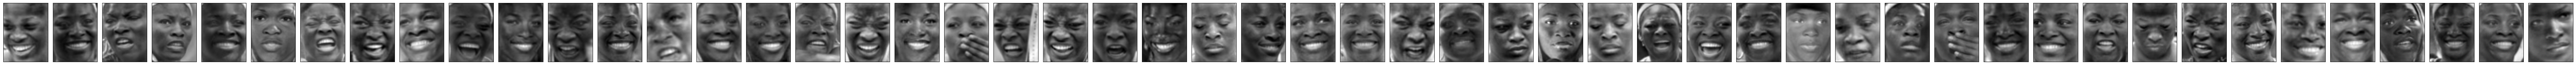

In [14]:
# rostro promedio para serena
serena_faces_mean = serena_faces - Xmean

plt.figure(figsize = (1.5 * n_col, 2.2 * n_row))
plt.subplots_adjust(0.6, 0.5, 1.5, 1.5)
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(serena_faces_mean.iloc[i].to_numpy().reshape((h, w)), cmap = plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

#### 3.3. Descomposición en Valores Singulares

Aplique la Descomposición en Valores Singulares a estas nuevas imágenes y retenga solo $K=1000$ valores singulares? ¿Qué proporción de la varianza representan esto valores singulares?

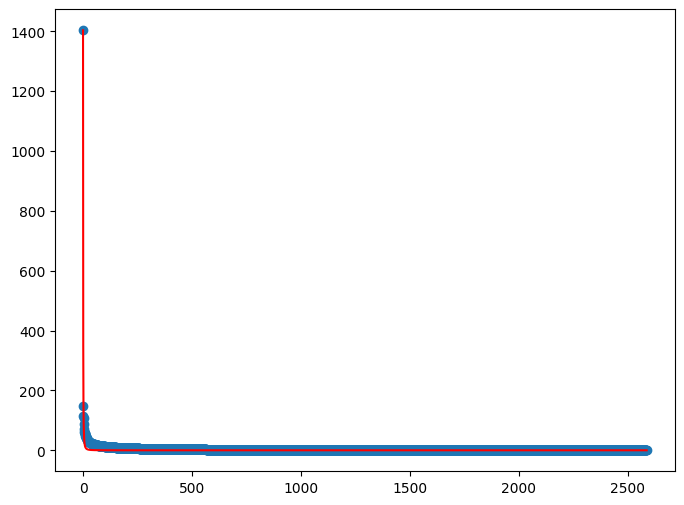

In [18]:
U,S,Vt = svd(X)

# observe cuan rapidamente caen los SVD
idx = range(len(S))
func = [S[0]/((i+1) ** 2) for i in idx ]

plt.figure(figsize = (8, 6))
plt.plot(idx, func, color = 'r')
plt.scatter(idx, S)

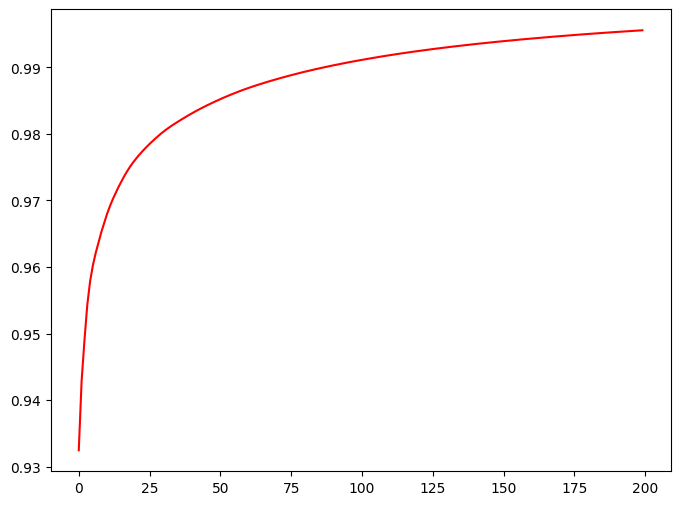

In [24]:
rg = 200
idx = range(0,rg)
var_explained = np.round(S**2/np.sum(S**2), decimals=6)

cumsum=var_explained[0:rg].cumsum()

plt.figure(figsize = (8, 6))
plt.plot(idx,cumsum , color = 'r')

In [26]:
var = sum(var_explained[0:rg])

print(f"La proporcion de varianza del modelo es de {var * 100} %")

La proporcion de varianza del modelo es de 99.55683898925781 %


#### 3.4. Representando los rostros en las bases

Las eigenfaces nos dice que cada rostro puede ser representado a partir de la aproximación a la matriz original por la matriz de dimensión reducida determinada en el punto anterior más el rostro promedio. Muestre que esto es posible para las imágenes de Serena Williams. Compare las imágenes reconstruidas con las originales.

In [27]:
n,k = X.shape

S2 = np.resize(S,[n,1])*np.eye(n,k) #ponemos los valores singulares en una matriz diagonal

l = 10

reconstructed = np.dot(U[:,0:l],np.dot(S2[0:l,0:l],Vt[0:l,:]))
reconstructed = pd.DataFrame(reconstructed)
reconstructed

0         1         2         3         4         5         6     \
0     0.267309  0.272866  0.287600  0.314487  0.344108  0.371981  0.396151   
1     0.144331  0.167902  0.201399  0.239358  0.263952  0.281278  0.309534   
2     0.397963  0.439300  0.496643  0.550680  0.579252  0.595066  0.611462   
3     0.437653  0.465428  0.505597  0.561144  0.622321  0.677313  0.721418   
4     0.284576  0.300645  0.331817  0.374105  0.405602  0.427470  0.450084   
...        ...       ...       ...       ...       ...       ...       ...   
2583  0.409929  0.408619  0.421412  0.453178  0.491614  0.525782  0.551491   
2584  0.375808  0.391932  0.417944  0.457780  0.501767  0.539587  0.565041   
2585  0.311451  0.320556  0.332286  0.355478  0.395332  0.432788  0.462193   
2586  0.162433  0.163231  0.182088  0.219089  0.267886  0.315231  0.361297   
2587  0.396712  0.419233  0.450922  0.488628  0.528613  0.568964  0.604070   

          7         8         9     ...      2904      2905      2906  \
0     0.416334  0.431791  0.447865  ...  0.309728  0.292512  0.270955   
1     0.340667  0.364543  0.388059  ...  0.726387  0.800549  0.876693   
2     0.632581  0.652013  0.663723  ...  0.686092  0.684846  0.659026   
3     0.761457  0.795517  0.817279  ...  0.266495  0.310097  0.348057   
4     0.476638  0.499950  0.514177  ...  0.272203  0.250760  0.224261   
...        ...       ...       ...  ...       ...       ...       ...   
2583  0.568194  0.579257  0.590261  ...  0.356079  0.377328  0.387309   
2584  0.580762  0.591060  0.606570  ...  0.423902  0.456541  0.471261   
2585  0.486291  0.507315  0.525818  ...  0.118134  0.155844  0.203736   
2586  0.399277  0.430905  0.457482  ...  0.786164  0.872035  0.938190   
2587  0.638091  0.670181  0.695542  ...  0.395648  0.352928  0.304085   

          2907      2908      2909      2910      2911      2912      2913  
0     0.244813  0.213456  0.179638  0.153904  0.135024  0.135790  0.148018  
1     0.929708  0.935516  0.897663  0.840880  0.763118  0.671155  0.589815  
2     0.596074  0.475114  0.320093  0.180423  0.067619 -0.024077 -0.070270  
3     0.375115  0.404621  0.424321  0.432784  0.429483  0.404171  0.367553  
4     0.188884  0.135324  0.068591  0.015311 -0.031399 -0.060472 -0.061801  
...        ...       ...       ...       ...       ...       ...       ...  
2583  0.388051  0.384637  0.378905  0.377361  0.365704  0.358315  0.355099  
2584  0.458978  0.425088  0.383378  0.343500  0.305005  0.269791  0.243121  
2585  0.255409  0.313383  0.377233  0.428789  0.467727  0.471120  0.449083  
2586  0.975971  0.989247  0.976939  0.951749  0.898750  0.824844  0.755484  
2587  0.250223  0.189433  0.125562  0.074498  0.050425  0.055467  0.074261  

[2588 rows x 2914 columns]

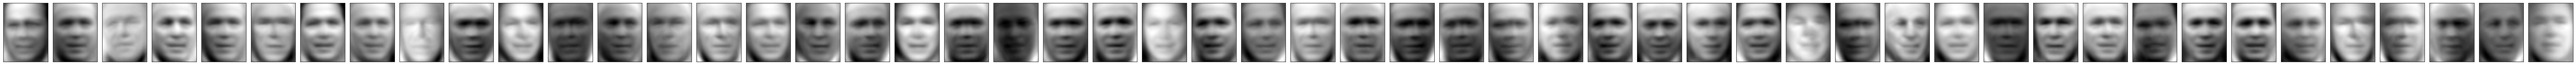

In [ ]:
# obtener los indices de Serena en el dataframe original
serena_idx = df[df['name'] == 'Serena Williams'].index

# seleccionar las imagenes reconstruidas usando los indices
serena_reconstructed = reconstructed.loc[serena_idx].reset_index(drop = True)

# visualizar las imagenes reconstruidas
plt.figure(figsize=(1.5 * n_col, 2.2 * n_row))
for i in range(len(serena_reconstructed)):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(serena_reconstructed.iloc[i].to_numpy().reshape((h, w)), cmap = plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

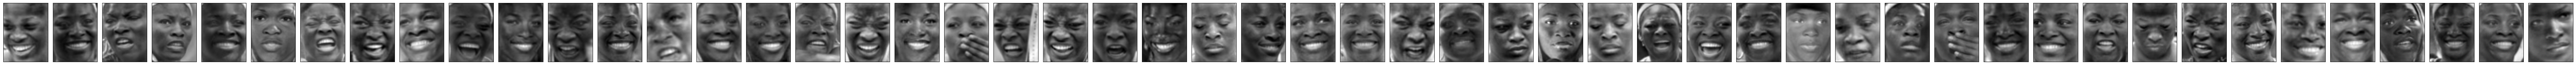

In [30]:
# rostro promedio para serena (original)
serena_faces_mean = serena_faces - Xmean

plt.figure(figsize = (1.5 * n_col, 2.2 * n_row))
plt.subplots_adjust(0.6, 0.5, 1.5, 1.5)
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(serena_faces_mean.iloc[i].to_numpy().reshape((h, w)), cmap = plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show()

### 4. Uniendo Aprendizaje No Supervisado y Supervisado

Dado que cada rostro puede ser representado por las eigenfaces, y la relación que existe entre componentes principales y la SVD, esto sugiere que los componentes principales aquí determinados pueden servir de insumo para un algoritmo de clasificación de aprendizaje supervisado. En este sección del taller haremos esto.

Para ello construiremos un modelo de clasificación logístico para predecir si la imagen pertenece a `George W Bush`  (el individuo con más imágenes en la base)  o no.

#### 4.1. Identificando a `George W Bush`

Cree una variable binaria que tome el valor 1 si la imagen pertenece a `George W Bush` y 0 en caso contrario.

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 4.2. Bases de Entrenamiento y Prueba.

Divida la base utilizada anteriormente en dos: 80% de la base de imágenes asígnelas a la base de entrenamiento y el 20% restante a la de prueba, utilice un `random_state=10101`.

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 4.3. Descomposición en Valores Singulares

Para la base de entrenamiento y de prueba, realice la descomposición en valores singulares (Recuerde recentrar las matrices para que tenga media 0).

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 4.4. Estimación de modelo de aprendizaje supervisado


Utilizando $k=1000$ valores singulares, construya los 1000 primeros componentes principales y úselos como predictores en su modelo logístico. Utilice como métrica de performance el porcentaje de imágenes de `George W Bush` clasificadas correctamente.

Para estimar su modelo logístico Utilice el `solver='sag`,`random_state=10101` y `max_iter=1000`. Como se muestra a continuación:



In [ ]:
from sklearn.linear_model import LogisticRegression

Modelo_Logistico = LogisticRegression(solver='sag',random_state=10101,max_iter=1000)

# Utilice este espacio para escribir el código restante.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 4.5. Mejorando el Ajuste

Trate ahora el número de valores singulares como un hiper-parámetro a encontrar. Emplee validación cruzada con 5 o 10 folds (dependiendo de su poder computacional) para encontrar el número óptimo de valores singulares. Con este modelo, evalúe el porcentaje de imágenes de `George W Bush` clasificadas correctamente en su muestra de prueba. Compare y discuta esta forma de elegir el número de variables con aquella utilizada en  4.4. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).